In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, linear_model, metrics

In [2]:
data = pd.read_csv('./data/prices-split-adjusted.csv', header=0, index_col='date', parse_dates=True)
tickers = data['symbol'].unique()
print("Ticker size: ", tickers.size)

Ticker size:  501


In [3]:
print(data.index)

DatetimeIndex(['2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-19',
               ...
               '2016-12-30', '2016-12-30', '2016-12-30', '2016-12-30',
               '2016-12-30', '2016-12-30', '2016-12-30', '2016-12-30',
               '2016-12-30', '2016-12-30'],
              dtype='datetime64[ns]', name='date', length=851264, freq=None)


In [4]:
print(data.columns)

Index(['symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')


In [5]:
def concat_data(tickers, data):
    def data_from_ticker(ticker):
        return data[data['symbol'] == ticker]
    datas = map(data_from_ticker, tickers)
    return pd.concat(datas, axis=1, keys=tickers)

In [6]:
partial_tickers = ['AMZN', 'AAPL']

In [7]:
concated_data = concat_data(partial_tickers, data)
print(concated_data.columns)

MultiIndex([('AMZN', 'symbol'),
            ('AMZN',   'open'),
            ('AMZN',  'close'),
            ('AMZN',    'low'),
            ('AMZN',   'high'),
            ('AMZN', 'volume'),
            ('AAPL', 'symbol'),
            ('AAPL',   'open'),
            ('AAPL',  'close'),
            ('AAPL',    'low'),
            ('AAPL',   'high'),
            ('AAPL', 'volume')],
           )


In [8]:
print(concated_data.shape)

(1762, 12)


In [9]:
print(concated_data.head())

             AMZN                                                              \
           symbol        open       close         low        high      volume   
date                                                                            
2010-01-04   AMZN  136.250000  133.899994  133.139999  136.610001   7599900.0   
2010-01-05   AMZN  133.429993  134.690002  131.809998  135.479996   8851900.0   
2010-01-06   AMZN  134.600006  132.250000  131.649994  134.729996   7178800.0   
2010-01-07   AMZN  132.009995  130.000000  128.800003  132.320007  11030200.0   
2010-01-08   AMZN  130.559998  133.520004  129.029999  133.679993   9830500.0   

             AAPL                                                           
           symbol       open      close        low       high       volume  
date                                                                        
2010-01-04   AAPL  30.490000  30.572857  30.340000  30.642857  123432400.0  
2010-01-05   AAPL  30.657143  30.625713  30

In [10]:
print(concated_data.tail())

             AMZN                                                             \
           symbol        open       close         low        high     volume   
date                                                                           
2016-12-23   AMZN  764.549988  760.590027  757.989990  766.500000  1976900.0   
2016-12-27   AMZN  763.400024  771.400024  761.200012  774.650024  2627400.0   
2016-12-28   AMZN  776.250000  772.130005  770.500000  780.000000  3279100.0   
2016-12-29   AMZN  772.400024  765.150024  760.849976  773.400024  3153500.0   
2016-12-30   AMZN  766.469971  749.869995  748.280029  767.400024  4125300.0   

             AAPL                                                              
           symbol        open       close         low        high      volume  
date                                                                           
2016-12-23   AAPL  115.589996  116.519997  115.589996  116.519997  14249500.0  
2016-12-27   AAPL  116.519997  117.2600

In [11]:
concated_data.sort_index(inplace=True)

In [12]:
concated_data.drop(inplace=True, axis=1, columns=[('AMZN', 'symbol'), ('AAPL', 'symbol')])

In [13]:
print(concated_data)

                  AMZN                                                  \
                  open       close         low        high      volume   
date                                                                     
2010-01-04  136.250000  133.899994  133.139999  136.610001   7599900.0   
2010-01-05  133.429993  134.690002  131.809998  135.479996   8851900.0   
2010-01-06  134.600006  132.250000  131.649994  134.729996   7178800.0   
2010-01-07  132.009995  130.000000  128.800003  132.320007  11030200.0   
2010-01-08  130.559998  133.520004  129.029999  133.679993   9830500.0   
...                ...         ...         ...         ...         ...   
2016-12-23  764.549988  760.590027  757.989990  766.500000   1976900.0   
2016-12-27  763.400024  771.400024  761.200012  774.650024   2627400.0   
2016-12-28  776.250000  772.130005  770.500000  780.000000   3279100.0   
2016-12-29  772.400024  765.150024  760.849976  773.400024   3153500.0   
2016-12-30  766.469971  749.869995  74

In [14]:
def get_technical_indicators(partial_tickers, dataset):
    for ticker in partial_tickers:
        # Create 7 and 21 days Moving Average
        dataset[(ticker, 'ma7')] = dataset[(ticker, 'close')].rolling(window=7).mean()
        dataset[(ticker, 'ma21')] = dataset[(ticker, 'close')].rolling(window=21).mean()

        # Create MACD
        dataset[(ticker, '26ema')] = dataset[(ticker, 'close')].ewm(span=26, adjust=False).mean()
        dataset[(ticker, '12ema')] = dataset[(ticker, 'close')].ewm(span=12, adjust=False).mean()
        dataset[(ticker, 'MACD')] = (dataset[(ticker, '12ema')] - dataset[(ticker, '26ema')])

        # Create Bollinger Bands
        dataset[(ticker, '20sd')] = dataset[(ticker, 'close')].rolling(20).std()
        dataset[(ticker, 'upper_band')] = dataset[(ticker, 'ma21')] + (dataset[(ticker, '20sd')]*2)
        dataset[(ticker, 'lower_band')] = dataset[(ticker, 'ma21')] - (dataset[(ticker, '20sd')]*2)

        # Create Exponential moving average
        dataset[(ticker, 'ema')] = dataset[(ticker, 'close')].ewm(com=0.5).mean()
    
    return dataset

In [15]:
data_ti = get_technical_indicators(partial_tickers, concated_data)
data_ti = data_ti[
    [
        ('AMZN', 'close'), 
        ('AMZN', 'ma7'), 
        ('AMZN', 'ma21'), 
        ('AMZN', '26ema'), 
        ('AMZN', '12ema'), 
        ('AMZN', 'MACD'),
        ('AMZN', '20sd'),
        ('AMZN', 'upper_band'),
        ('AMZN', 'lower_band'),
        ('AMZN', 'ema'),
        ('AAPL', 'close'), 
        ('AAPL', 'ma7'), 
        ('AAPL', 'ma21'), 
        ('AAPL', '26ema'), 
        ('AAPL', '12ema'), 
        ('AAPL', 'MACD'),
        ('AAPL', '20sd'),
        ('AAPL', 'upper_band'),
        ('AAPL', 'lower_band'),
        ('AAPL', 'ema')
    ]
]
data_ti.describe()

AMZN                                                      \
             close          ma7         ma21        26ema        12ema   
count  1762.000000  1756.000000  1742.000000  1762.000000  1762.000000   
mean    337.899058   337.523477   336.644335   333.414598   335.931770   
std     189.109339   188.268997   186.278257   185.494676   187.544782   
min     108.610001   111.097143   116.715238   118.582401   114.721560   
25%     193.377506   193.076428   194.560833   192.431129   193.355628   
50%     282.915008   284.707857   288.415476   275.243673   278.984766   
75%     398.014999   397.536432   395.182264   391.301345   395.903474   
max     844.359985   839.319999   829.704767   818.128587   829.331393   

                                                                        \
              MACD         20sd   upper_band   lower_band          ema   
count  1762.000000  1743.000000  1742.000000  1742.000000  1762.000000   
mean      2.517172    10.505168   357.661311   315.627359   337.722627   
std       7.751534     7.938898   195.825991   177.639252   188.957691   
min     -35.165931     1.775140   122.322693   105.863385   109.658293   
25%      -1.633561     5.267711   207.944274   178.325894   192.881308   
50%       2.364006     7.638119   301.318207   264.160315   282.368785   
75%       5.679020    12.730621   418.507338   376.141701   397.677288   
max      31.238396    45.107982   866.575872   809.178586   841.477028   

              AAPL                                                      \
             close          ma7         ma21        26ema        12ema   
count  1762.000000  1756.000000  1742.000000  1762.000000  1762.000000   
mean     79.402683    79.423041    79.477209    78.806981    79.136330   
std      28.330794    28.228704    28.000363    28.263487    28.294931   
min      27.435715    27.826735    28.356939    28.769880    28.229743   
25%      55.450000    55.269897    55.553231    55.113018    54.974710   
50%      78.435711    78.597449    78.973129    78.212577    78.913467   
75%     103.092503   102.153213   102.304405   102.178820   102.037628   
max     133.000000   131.169996   129.722856   129.301171   130.239032   

                                                                        
              MACD         20sd   upper_band   lower_band          ema  
count  1762.000000  1743.000000  1742.000000  1742.000000  1762.000000  
mean      0.329349     2.197812    83.874285    75.080133    79.378395  
std       1.494569     1.152239    29.259224    26.880447    28.324034  
min      -4.432348     0.336217    29.405169    26.752246    27.719173  
25%      -0.396003     1.316223    58.864047    51.962547    55.186385  
50%       0.337880     1.984627    83.808217    74.045419    78.452378  
75%       1.194927     2.850527   110.189286    96.717291   103.164787  
max       4.883714     7.332196   135.083227   126.936587   132.016818

In [16]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
    
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()
    
    plt.show()

/anaconda3/envs/ny50/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


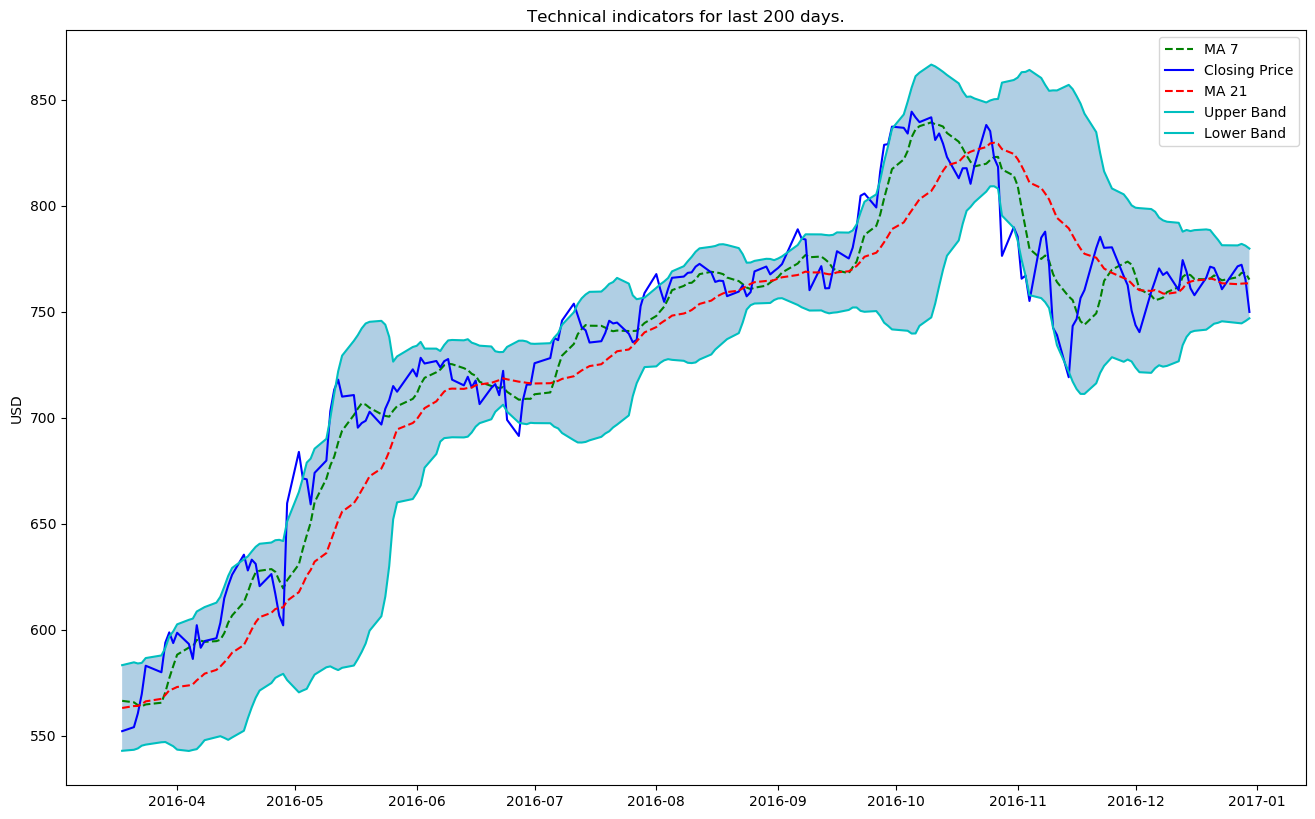

In [17]:
plot_technical_indicators(data_ti[['AMZN']].droplevel(0, axis=1), 200)

In [18]:
def split_data(data):
        total_length = len(data)
        train_index = round(0.8 * total_length)
        
        train = data[:int(train_index), :]
        test = data[int(train_index):, :]
        
        return train, test

In [19]:
amzn_data = data_ti[['AMZN']].droplevel(0, axis=1)
amzn_data.describe()

,close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
count,1762.000000,1756.000000,1742.000000,1762.000000,1762.000000,1762.000000,1743.000000,1742.000000,1742.000000,1762.000000
mean,337.899058,337.523477,336.644335,333.414598,335.931770,2.517172,10.505168,357.661311,315.627359,337.722627
std,189.109339,188.268997,186.278257,185.494676,187.544782,7.751534,7.938898,195.825991,177.639252,188.957691
min,108.610001,111.097143,116.715238,118.582401,114.721560,-35.165931,1.775140,122.322693,105.863385,109.658293
25%,193.377506,193.076428,194.560833,192.431129,193.355628,-1.633561,5.267711,207.944274,178.325894,192.881308
50%,282.915008,284.707857,288.415476,275.243673,278.984766,2.364006,7.638119,301.318207,264.160315,282.368785
75%,398.014999,397.536432,395.182264,391.301345,395.903474,5.679020,12.730621,418.507338,376.141701,397.677288
max,844.359985,839.319999,829.704767,818.128587,829.331393,31.238396,45.107982,866.575872,809.178586,841.477028


In [20]:
amzn_data.dropna(inplace=True)
amzn_data['close_adj'] = amzn_data['close']
amzn_data.drop(axis=1, columns=['close'], inplace=True)
amzn_data.head()

,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,close_adj
date,,,,,,,,,,
2010-02-02,121.567144,126.572857,126.492629,123.313985,-3.178644,4.823779,136.220415,116.925300,119.068111,118.120003
2010-02-03,121.394287,125.868096,125.945027,122.665679,-3.279348,4.636742,135.141580,116.594611,119.089369,119.099998
2010-02-04,120.888573,124.975239,125.203914,121.630959,-3.572954,4.804807,134.584852,115.365625,116.989791,115.940002
2010-02-05,120.122858,124.267620,124.625105,120.978504,-3.646601,4.887152,134.041923,114.493316,117.256596,117.389999
2010-02-08,118.808573,123.640477,124.047690,120.340273,-3.707417,4.588413,132.817303,114.463651,116.972200,116.830002


In [21]:
train, test = split_data(amzn_data.values)
print(train)

[[121.56714429 126.57285748 126.49262898 ... 116.92529965 119.06811071
  118.120003  ]
 [121.39428714 125.86809576 125.94502668 ... 116.59461132 119.0893689
  119.099998  ]
 [120.88857271 124.97523862 125.20391374 ... 115.36562496 116.98979097
  115.940002  ]
 ...
 [528.33714943 513.73286214 504.50050015 ... 469.48036038 526.10108701
  525.909973  ]
 [528.01714214 516.99333695 506.3641648  ... 476.83368087 528.47367767
  529.659973  ]
 [527.23285786 519.66190881 508.22756148 ... 482.96139638 530.50457256
  531.52002   ]]


In [22]:
def normalize_data(train, test):
        normalizer = preprocessing.Normalizer()
        train = normalizer.fit_transform(train)
        test = normalizer.transform(test)        
        return train, test

In [23]:
train, test = normalize_data(train, test)
print("Train data shape: ", train.shape)

Train data shape:  (1394, 10)


In [24]:
print("Test data shape: ", test.shape)

Test data shape:  (348, 10)


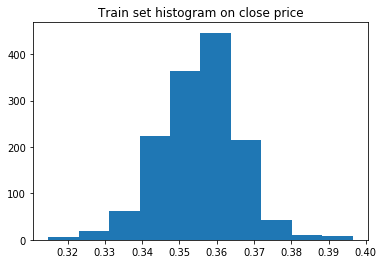

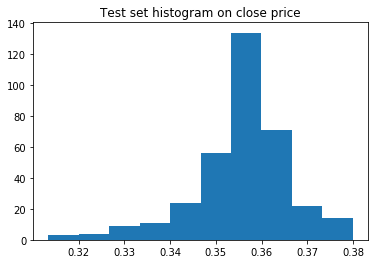

In [36]:
plt.hist(train[:,-1])
plt.title("Train set histogram on close price") 
plt.show()

plt.hist(test[:,-1])
plt.title("Test set histogram on close price") 
plt.show()

In [25]:
def formate_data(data, amount_of_features, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(data) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(data[index: (index + x_len), :-1])
            # We just want the close price as target variable
            y_s.append(data[(index + x_len):(index + x_len + y_len), -1])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [27]:
print(test[(0 + 24):(0 + 24 + 7), -1])

[0.36780614 0.36157018 0.35933544 0.35715205 0.35203281 0.34237534
 0.33971869]


In [28]:
x_train, y_train = formate_data(train, 10, 24, 7)
x_test, y_test = formate_data(test, 10, 24, 7)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

X train shape: (1363, 24, 9)
Y train shape: (1363, 7)
X test shape: (317, 24, 9)
Y test shape: (317, 7)


In [46]:
X = np.reshape(x_train, (1363, 24 * 9))
y = y_train
reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y))

0.202391526555368


/anaconda3/envs/ny50/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [48]:
Xt = np.reshape(x_test, (317, 24 * 9))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (317, 7)
pred shape:  (317, 7)


In [50]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.00010016126198840575


In [59]:
def plot_results_against_true_data(tested_data, true_data, title="Results comparison"):
        plt.figure(figsize = (15,6))
        # style
        plt.style.use('seaborn-darkgrid')

        plt.plot(
            range(len(tested_data)), 
            tested_data, 
            marker='', 
            color="blue", 
            linewidth=0.5, 
            alpha=1, 
            label="Predicted Data"
        )

        plt.plot(
            range(len(true_data)), 
            true_data, 
            marker='', 
            color="black", 
            linewidth=0.5, 
            alpha=0.8, 
            label="Real Data"
        )

        plt.legend(loc=2, ncol=2)
        plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.show()

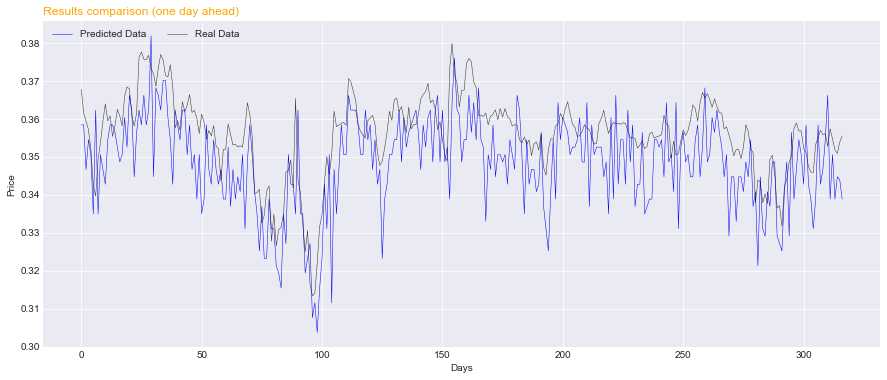

In [60]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

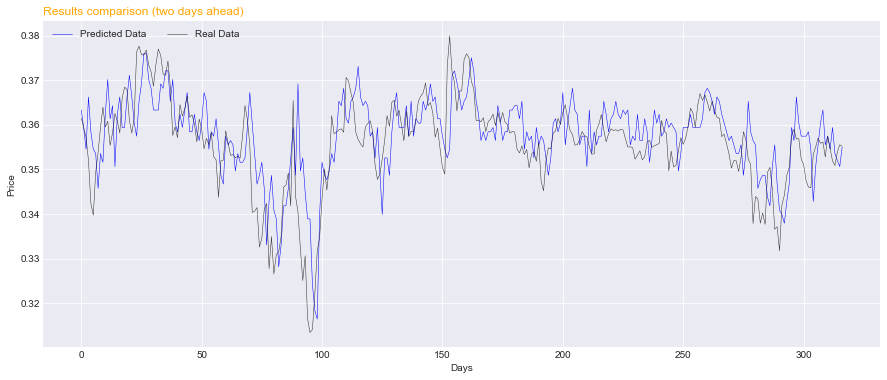

In [62]:
plot_results_against_true_data(pred[:,1], yt[:,1], title="Results comparison (two days ahead)")

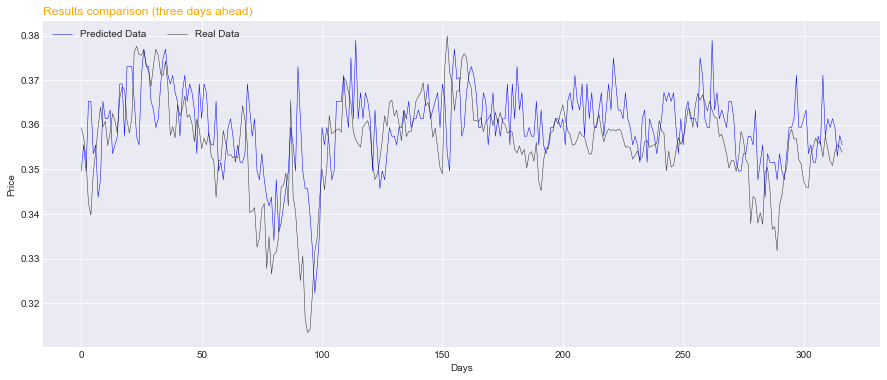

In [63]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three days ahead)")

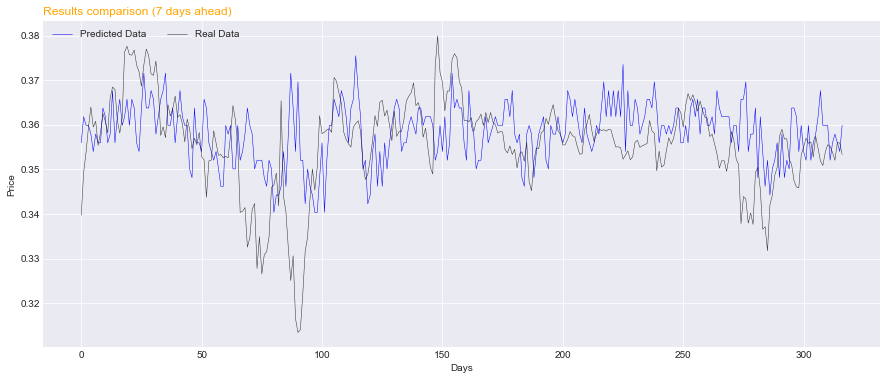

In [64]:
plot_results_against_true_data(pred[:,6], yt[:,6], title="Results comparison (7 days ahead)")